In [1]:
import torch 
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

from attrdict import AttrDict
import numpy as np
import random

import matplotlib.pyplot as plt

In [2]:
args = AttrDict()
args.seeds = 1111

In [3]:
random_seed = args.seeds
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [4]:
class PINN_Basic(nn.Module):
    def __init__(self,nn_model, pdetype = 'v1' ):
        super(PINN_Basic,self).__init__()

        self.pde_type = pdetype
        self.nn_model = nn_model
        self.in_dim =  nn_model.in_dim         
        self.out_dim = nn_model.out_dim
        self.reg_lambda = 1
        
        #self.mse_loss = nn.MSELoss(reduce=False)
        self.mse_loss = nn.MSELoss(reduce=True,reduction = 'mean')
            
    def forward(self,xt):        
        u_xt = self.nn_model(xt)                
        return u_xt
    
    
    def compute_loss(self,xt_rd,y_rd,xt_init,u_init,xt_bd,u_bd):
        loss_rd = self.compute_pdeloss_rd(xt_rd,y_rd)
        loss_init = self.compute_pdeloss_bdinit(xt_init,u_init)
        loss_bd = self.compute_pdeloss_bdinit(xt_bd,u_bd)        
        #loss = loss_rd + self.reg_lambda*(0.5*loss_init + 0.5*loss_bd)
        #return loss_rd + self.reg_lambda*(0.5*loss_init + 0.5*loss_bd)
        return loss_rd,loss_init,loss_bd

    
    def compute_pdeloss_rd(self,xt,y):        
        xt_grad = xt.clone()
        xt_grad.requires_grad = True

        u = self.nn_model(xt_grad)                
        du_dxt= autograd.grad(u,xt_grad,torch.ones_like(u).to(u.device),retain_graph=True,create_graph=True)[0]
        du_dx_dxt = autograd.grad(du_dxt[:,:,:-1],xt_grad,torch.ones_like(du_dxt[:,:,:-1]).to(xt_grad.device),retain_graph=True,create_graph=True)[0]
        du_dx = du_dxt[:,:,:-1]
        du_dxx = du_dx_dxt[:,:,:-1]

        # compute loss depending on pde
        pde_loss = self.mse_loss(0.01*du_dxx,y)
        
        return pde_loss
    
    
    def compute_pdeloss_bdinit(self,xt,y):        
        u = self.nn_model(xt)                
        # compute loss depending on pde
        pde_loss = self.mse_loss(u,y)
        
        return pde_loss

In [6]:
#torch.uniform(-3, -2)
#F.softplus(torch.tensor([-20.,-10.]), beta=1, threshold=20)

In [7]:
#  ----------------------------------------------------
#https://github.com/JavierAntoran/Bayesian-Neural-Networks/blob/master/src/Bayes_By_Backprop_Local_Reparametrization/model.py
#  ----------------------------------------------------
import torch.nn.functional as F
from torch.autograd import Variable

def KLD_cost(mu_p, sig_p, mu_q, sig_q):
    KLD = 0.5 * (2 * torch.log(sig_p / sig_q) - 1 + (sig_q / sig_p).pow(2) + ((mu_p - mu_q) / sig_p).pow(2)).sum()
    # https://arxiv.org/abs/1312.6114 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    return KLD

class BayesLinear_localreparam(nn.Module):
    """Linear Layer where activations are sampled from a fully factorised normal which is given by aggregating
     the moments of each weight's normal distribution. The KL divergence is obtained in closed form. Only works
      with gaussian priors.
    """
    def __init__(self, n_in, n_out, prior_sig=0.1**2):
        super(BayesLinear_localreparam, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.prior_sig = prior_sig

        # Learnable parameters
        self.W_mu = nn.Parameter(torch.Tensor(self.n_in, self.n_out).uniform_(-0.1, 0.1))        
        torch.nn.init.xavier_uniform(self.W_mu.data)
        #self.W_mu = nn.Parameter(torch.Tensor(self.n_in, self.n_out).xavier_uniform_())        
        self.W_p = nn.Parameter(torch.Tensor(self.n_in, self.n_out).uniform_(-6, -5))

        self.b_mu = nn.Parameter(torch.Tensor(self.n_out).uniform_(-1e-8, 1e-8))
        self.b_p = nn.Parameter(torch.Tensor(self.n_out).uniform_(-6, -5))
        self.bias = True

    def forward(self, X, sample=False):
        #         print(self.training)

        if not self.training and not sample:  # This is just a placeholder function
            #print('check weight sampling x')            
            output = torch.mm(X, self.W_mu) + self.b_mu.expand(X.size()[0], self.n_out)
            return output, 0, 0

        else:
            #print('check weight sampling o')
            # calculate std
            std_w = 1e-6 + F.softplus(self.W_p, beta=1, threshold=20)
            std_b = 1e-6 + F.softplus(self.b_p, beta=1, threshold=20)

            act_W_mu = torch.mm(X, self.W_mu)  # self.W_mu + std_w * eps_W
            act_W_std = torch.sqrt(torch.mm(X.pow(2), std_w.pow(2)))

            # Tensor.new()  Constructs a new tensor of the same data type as self tensor.
            # the same random sample is used for every element in the minibatch output
            eps_W = Variable(self.W_mu.data.new(act_W_std.size()).normal_(mean=0, std=1))
            eps_b = Variable(self.b_mu.data.new(std_b.size()).normal_(mean=0, std=1))

            act_W_out = act_W_mu + act_W_std * eps_W  # (batch_size, n_output)
            act_b_out = self.b_mu + std_b * eps_b

            output = act_W_out + act_b_out.unsqueeze(0).expand(X.shape[0], -1)

            kld = KLD_cost(mu_p=0, sig_p=self.prior_sig, mu_q=self.W_mu, sig_q=std_w)  
            kld = kld + KLD_cost(mu_p=0, sig_p=0.1, mu_q=self.b_mu,sig_q=std_b)
            return output, kld, 0

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.n_in, self.n_out, self.bias is not None
        )        
    
# Blinear1 = BayesLinear_localreparam(2,10)    
# Blinear1


class BayesMLP_Layer(nn.Module):
    #def __init__(self,in_dim=1,out_dim=1,hdim = 50 ):
    def __init__(self,in_dim=1,out_dim=1,hdim = 20 ):
        
        super(BayesMLP_Layer,self).__init__()

        #self.in_dim = in_dim + 1
        self.in_dim = in_dim + 1        
        self.out_dim = out_dim
        self.hdim = hdim

#         linear1 = nn.Linear(self.in_dim,self.hdim )
#         linear2 = nn.Linear(self.hdim,self.hdim)
#         linear3 = nn.Linear(self.hdim,self.hdim)
#         linear4 = nn.Linear(self.hdim,self.out_dim)

#         activation =  nn.Tanh()
#         linear = [linear1,
#                   activation,
#                   linear2,
#                   activation,
#                   linear3,
#                   activation,
#                   linear4]
#         self.mapping = nn.Sequential(*linear)

#         def init_weights(module):
#             if isinstance(module, nn.Linear):
#                 torch.nn.init.xavier_uniform(module.weight)
#                 module.bias.data.fill_(0.0)
                
#        self.mapping.apply(init_weights)

        self.act = nn.Tanh()
        self.b_linear1 = BayesLinear_localreparam( self.in_dim,self.hdim )
        self.b_linear2 = BayesLinear_localreparam( self.hdim,self.hdim )
        self.b_linear3 = BayesLinear_localreparam( self.hdim,self.hdim )
        self.b_linear4 = BayesLinear_localreparam( self.hdim,self.out_dim )
        
                
    def forward(self, x ,use_sample = True):                
        need_reshape = False
        tlqw ,tlpw = 0,0
        
        if x.dim() == 3:
            nb,ndata,ndim = x.shape
            x = x.reshape(-1,ndim)
            need_reshape=True
            
        #--------------------------
        #layer 1
        #--------------------------        
        x, lqw, lpw = self.b_linear1(x,use_sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        x = self.act(x)        
        #--------------------------
        #layer 2
        #--------------------------        
        x, lqw, lpw = self.b_linear2(x,use_sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        x = self.act(x)        
        #--------------------------
        #layer 3
        #--------------------------        
        x, lqw, lpw = self.b_linear3(x,use_sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        x = self.act(x)
        #--------------------------
        #layer 4
        #--------------------------        
        y, lqw, lpw = self.b_linear4(x,use_sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        
        if need_reshape:
            y = y.reshape(nb,ndata,self.out_dim)                
            
        return y, tlqw, tlpw
    
    
    

In [8]:
#xt_bd.size().item()

In [9]:
#--------------------------------------------------------
# reference:
# https://github.com/JavierAntoran/Bayesian-Neural-Networks/blob/master/src/Bayes_By_Backprop_Local_Reparametrization/model.py
#--------------------------------------------------------
class PINN_BBB(PINN_Basic):
    
    def __init__(self,nn_model, pdetype = 'v1',num_sample_intrain=5, num_sample_intest=10, eps=1e-16):
    #def __init__(self,in_dim = 1, out_dim = 1, pdetype = 'v1',num_sample_intrain=5, num_sample_intest=10, eps=1e-16):
        
        super(PINN_BBB,self).__init__(nn_model, pdetype)

        #self.nn_model =  BayesMLP_Layer(in_dim = in_dim,out_dim = out_dim)
        self.num_sample_intrain = num_sample_intrain
        self.num_sample_intest = num_sample_intest

    def compute_preddist(self,xt,num_sample=10):        
        pred_list = []
        for _ in range(num_sample):
            pred_list.append(self.forward(xt)[0].unsqueeze(dim=-1))
        pred_list = torch.cat(pred_list,dim=-1)    
        emp_pmu = pred_list.mean(dim=-1) 
        emp_pstd = pred_list.std(dim=-1) 
        
        #return emp_pmu,emp_pstd,pred_list
        return emp_pmu,emp_pstd

    

    def forward(self,xt,use_sample=True):        
        u_xt, tlqw, tlpw = self.nn_model(xt,use_sample)                            
        return u_xt, tlqw, tlpw
    

    def compute_loss(self,xt_rd,y_rd,xt_init,u_init,xt_bd,u_bd):
        loss_rd,reg_rd = 0,0
        loss_init,reg_init = 0,0
        loss_bd,reg_bd = 0,0
        
        for i in range(self.num_sample_intrain):        
            i_loss_rd,i_reg_rd      = self.compute_pdeloss_rd(xt_rd,y_rd)            
            loss_rd = loss_rd + i_loss_rd
            reg_rd = reg_rd + i_reg_rd
            
            i_loss_init,i_reg_init  = self.compute_pdeloss_bdinit(xt_init,u_init)
            loss_init = loss_init + i_loss_init
            reg_init = reg_init + i_reg_init

            i_loss_bd,i_reg_bd      = self.compute_pdeloss_bdinit(xt_bd,u_bd)        
            loss_bd = loss_bd + i_loss_bd
            reg_bd = reg_bd + i_reg_bd
            
        loss_rd, reg_rd = loss_rd/self.num_sample_intrain, reg_rd/self.num_sample_intrain    
        loss_init, reg_init = loss_init/self.num_sample_intrain, reg_init/self.num_sample_intrain    
        loss_bd, reg_bd = loss_bd/self.num_sample_intrain, reg_bd/self.num_sample_intrain    
        
        return (loss_rd,reg_rd),(loss_init,reg_init),(loss_bd,reg_bd)

    
    def compute_pdeloss_rd(self,xt,y):        
        xt_grad = xt.clone()
        xt_grad.requires_grad = True

        u, tlqw, tlpw = self.nn_model(xt_grad)                
        # ------------------------------        
        # compute regloss by prior
        # ------------------------------        
        nbatch = np.prod(xt_bd.shape[:2])
        reg_loss = (tlqw - tlpw)/nbatch

        # ------------------------------
        # compute pde bd loss
        # ------------------------------        
        du_dxt= autograd.grad(u,xt_grad,torch.ones_like(u).to(u.device),retain_graph=True,create_graph=True)[0]
        du_dx_dxt = autograd.grad(du_dxt[:,:,:-1],xt_grad,torch.ones_like(du_dxt[:,:,:-1]).to(xt_grad.device),retain_graph=True,create_graph=True)[0]
        du_dx = du_dxt[:,:,:-1]
        du_dxx = du_dx_dxt[:,:,:-1]

        # compute loss depending on pde
        pde_loss = self.mse_loss(0.01*du_dxx,y)
            
        return pde_loss,reg_loss
    
    
    def compute_pdeloss_bdinit(self,xt,y):        
        u, tlqw, tlpw = self.nn_model(xt)
        # ------------------------------
        # compute regloss by prior        
        # ------------------------------        
        nbatch = np.prod(xt_bd.shape[:2])
        reg_loss = (tlqw - tlpw)/nbatch
        
        # ------------------------------
        # compute pde init loss
        # ------------------------------                
        # compute loss depending on pde
        pde_loss = self.mse_loss(u,y)
        
        return pde_loss,reg_loss    


## target problem: 1d nonlinear Poisson equation

In [10]:
#---------------------------------
# data configuration
#---------------------------------
dataconfig = AttrDict()

dataconfig.in_dim,dataconfig.out_dim  = 1,1
#dataconfig.noisestd = .5
#dataconfig.noisestd = 0.25
#dataconfig.noisestd = 0.1
dataconfig.noisestd = 0.01

#nb,nobs = 16,16 #(nsensors=16)

dataconfig.nb,dataconfig.nobs = 8,32 #(nsensors=32)

dataconfig.xmin,dataconfig.xmax = -0.7,0.7
dataconfig.tmin,dataconfig.tmax = 0,1

dataconfig

AttrDict({'in_dim': 1, 'out_dim': 1, 'noisestd': 0.01, 'nb': 8, 'nobs': 32, 'xmin': -0.7, 'xmax': 0.7, 'tmin': 0, 'tmax': 1})

In [57]:
def gen_obs(dataconfig):
    
    u = lambda x: torch.pow(torch.sin(6*x),3)
    f = lambda x: (6**3)*torch.sin(6*x)*torch.pow(torch.cos(6*x),2) - 3*(6**2)*torch.pow(torch.sin(6*x),3)
  
    # ----------------------------
    # gen datset on rd
    # ----------------------------    
    x = dataconfig.xmin  + (dataconfig.xmax  - dataconfig.xmin)* torch.rand(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
    g_noise = dataconfig.noisestd*torch.randn(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
    t = (dataconfig.tmax  - dataconfig.tmin)* torch.rand(dataconfig.nb,1,1 ).repeat(1,dataconfig.nobs,1)

    f_xt = f(x)
    y_rd = 0.01*f_xt + g_noise     
    xt_rd = torch.cat([x,t],dim=-1)
    u_xt = u(x)
    

    # ----------------------------
    # gen datset on init
    # ----------------------------    
    x = dataconfig.xmin  + (dataconfig.xmax  - dataconfig.xmin)* torch.rand(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
    g_noise = dataconfig.noisestd*torch.randn(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
    t = 0*torch.rand(dataconfig.nb,1,1 ).repeat(1,dataconfig.nobs,1)
    u_init = u(x)
    xt_init = torch.cat([x,t],dim=-1)

    # ----------------------------
    # gen datset on bd
    # ----------------------------    
    x = torch.cat([dataconfig.xmin* torch.ones(dataconfig.nb,dataconfig.nobs//2,dataconfig.in_dim ),
                   dataconfig.xmax* torch.ones(dataconfig.nb,dataconfig.nobs//2,dataconfig.in_dim )],dim=-2)
     
    #g_noise = dataconfig.noisestd*torch.randn(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
    t = torch.rand(dataconfig.nb,dataconfig.nobs,1  )
    u_bd = u(x)
    #y_bd = u_bd      
    xt_bd = torch.cat([x,t],dim=-1)
        
    #return (xt_rd,y_rd,f_xt),(xt_init,u_init),(xt_bd,u_bd)    
    return (xt_rd,y_rd,f_xt,u_xt),(xt_init,u_init),(xt_bd,u_bd)    


    

In [58]:
dataconfig

AttrDict({'in_dim': 1, 'out_dim': 1, 'noisestd': 0.01, 'nb': 8, 'nobs': 32, 'xmin': -0.7, 'xmax': 0.7, 'tmin': 0, 'tmax': 1})

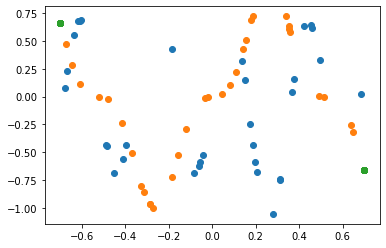

In [60]:
rd_set,init_set,bd_set = gen_obs(dataconfig)

xt_rd,y_rd,f,u_rd = rd_set
xt_init,u_init = init_set
xt_bd,u_bd = bd_set

bidx = 1
plt.scatter(xt_rd[bidx,:,0].cpu().data.numpy(),y_rd[bidx,:,0].cpu().data.numpy())
plt.scatter(xt_init[bidx,:,0].cpu().data.numpy(),u_init[bidx,:,0].cpu().data.numpy())
plt.scatter(xt_bd[bidx,:,0].cpu().data.numpy(),u_bd[bidx,:,0].cpu().data.numpy())

#plt.scatter(xt_init[:,0].cpu().data.numpy(),u_init[:,0].cpu().data.numpy())
# plt.scatter(xt[:,0].cpu().data.numpy(),f[:,0].cpu().data.numpy())


In [14]:
# bayes_mlp = BayesMLP_Layer(in_dim = 1, out_dim=1)
# bayes_mlp

In [15]:
#bayes_mlp

In [16]:
#len(rd_set[:-1])

In [61]:
model = PINN_BBB( BayesMLP_Layer(in_dim = 1, out_dim=1))
#model = PINN_BBB( in_dim = 1,out_dim = 1)

model

/home/yohan/Myenv/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/home/yohan/Myenv/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


PINN_BBB(
  (nn_model): BayesMLP_Layer(
    (act): Tanh()
    (b_linear1): BayesLinear_localreparam(in_features=2, out_features=20, bias=True)
    (b_linear2): BayesLinear_localreparam(in_features=20, out_features=20, bias=True)
    (b_linear3): BayesLinear_localreparam(in_features=20, out_features=20, bias=True)
    (b_linear4): BayesLinear_localreparam(in_features=20, out_features=1, bias=True)
  )
  (mse_loss): MSELoss()
)

In [62]:
trainconfig = AttrDict()

trainconfig.nepochs = 2000
trainconfig.lr = 1e-3
trainconfig.weightdecay = 1e-4
trainconfig.obsperiod = 50

trainconfig.swag_init_rate = .5
trainconfig.swag_start_nepochs = int(trainconfig.nepochs*trainconfig.swag_init_rate)
trainconfig.swag_updateperiod = 25

#trainconfig.bbb_reglambda = 1e-4
trainconfig.bbb_reglambda = 5e-5

optimizer = torch.optim.Adam(model.parameters(), lr=trainconfig.lr,weight_decay=trainconfig.weightdecay)


In [19]:
# loss_rd,loss_init,loss_bd

In [20]:
#loss_rd,loss_init,loss_bd = model.compute_loss(*rd_set[:-1],*init_set,*bd_set)

In [63]:
model.train()
for j in range(1,trainconfig.nepochs+1):
    rd_set,init_set,bd_set = gen_obs(dataconfig)
    #loss_rd,loss_init,loss_bd = model.compute_loss(*rd_set[:-1],*init_set,*bd_set)
    loss_rd,loss_init,loss_bd = model.compute_loss(*rd_set[:2],*init_set,*bd_set)
    
    loss_data = loss_rd[0] + 0.5*(loss_init[0] + loss_bd[0]) 
    loss_reg = loss_rd[1] + 0.5*(loss_init[1] + loss_bd[1])
    loss = loss_data + trainconfig.bbb_reglambda*loss_reg
        
    #update model params
    optimizer.zero_grad()        
    loss.backward()
    optimizer.step()
    
#     if (trainconfig.start_nepochs <= j and
#        (j - trainconfig.start_nepochs) % trainconfig.updateperiod== 0
#     ):
#         print('update at {}'.format(j))
#         model.collect_model()

        
    if j % trainconfig.obsperiod  == 0:
        print('[{} /{}]: loss {:.2f}, loss_data {:.2f}, reglam*loss_reg {:.2f}, loss_reg {:.2f}'.
              format(j,trainconfig.nepochs,loss,loss_data,trainconfig.bbb_reglambda*loss_reg,loss_reg))
        #print('[{} /{}]: tr loss: {:.2f} \t {:.2f},{:.2f},{:.2f}'.format(j,trainconfig.nepochs,loss,loss_rd,loss_init,loss_bd))
        

[50 /2000]: loss 0.63, loss_data 0.55, reglam*loss_reg 0.09, loss_reg 1737.18
[100 /2000]: loss 0.61, loss_data 0.53, reglam*loss_reg 0.08, loss_reg 1619.33
[150 /2000]: loss 0.61, loss_data 0.53, reglam*loss_reg 0.08, loss_reg 1522.38
[200 /2000]: loss 0.55, loss_data 0.48, reglam*loss_reg 0.07, loss_reg 1470.07
[250 /2000]: loss 0.57, loss_data 0.49, reglam*loss_reg 0.07, loss_reg 1473.83
[300 /2000]: loss 0.53, loss_data 0.45, reglam*loss_reg 0.08, loss_reg 1513.53
[350 /2000]: loss 0.45, loss_data 0.37, reglam*loss_reg 0.08, loss_reg 1599.73
[400 /2000]: loss 0.43, loss_data 0.35, reglam*loss_reg 0.08, loss_reg 1607.37
[450 /2000]: loss 0.39, loss_data 0.31, reglam*loss_reg 0.08, loss_reg 1605.15
[500 /2000]: loss 0.38, loss_data 0.29, reglam*loss_reg 0.08, loss_reg 1635.52
[550 /2000]: loss 0.37, loss_data 0.29, reglam*loss_reg 0.08, loss_reg 1653.04
[600 /2000]: loss 0.36, loss_data 0.28, reglam*loss_reg 0.08, loss_reg 1628.28
[650 /2000]: loss 0.30, loss_data 0.22, reglam*loss_r

KeyboardInterrupt: 

## eval mode

In [64]:
model.eval()

PINN_BBB(
  (nn_model): BayesMLP_Layer(
    (act): Tanh()
    (b_linear1): BayesLinear_localreparam(in_features=2, out_features=20, bias=True)
    (b_linear2): BayesLinear_localreparam(in_features=20, out_features=20, bias=True)
    (b_linear3): BayesLinear_localreparam(in_features=20, out_features=20, bias=True)
    (b_linear4): BayesLinear_localreparam(in_features=20, out_features=1, bias=True)
  )
  (mse_loss): MSELoss()
)

In [71]:
rd_set,init_set,bd_set = gen_obs(dataconfig)

xt_rd,y_rd,f,u_rd = rd_set
xt_init,u_init = init_set
xt_bd,u_bd = bd_set

In [72]:
pred_mu,pred_std = model.compute_preddist(xt_rd,num_sample=10)


In [73]:
def sort_xy(x,y):
#     x_sorted,idx_sorted = torch.sort(xt_rd[j,:,0])
#     y_sorted = pred_mu[j,:,0][idx_sorted]
    x_sorted,idx_sorted = torch.sort(x)
    y_sorted = y[idx_sorted]
    return x_sorted.cpu().data.numpy(), y_sorted.cpu().data.numpy()



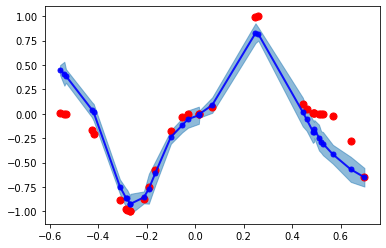

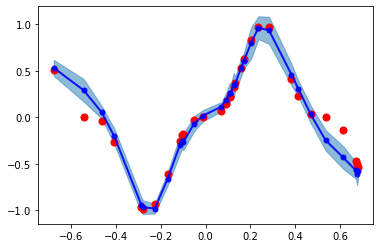

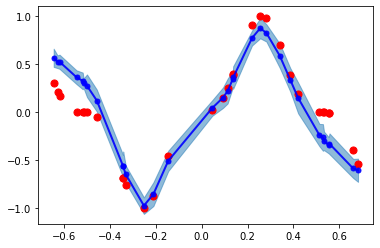

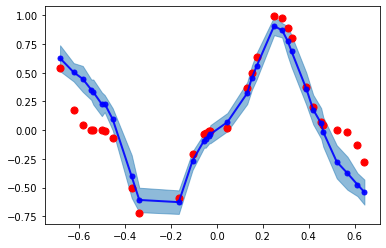

In [74]:
#for x_rd,y_rd,u_rd in xt_rd,u:
#figure()
for j in range(4):
    #model.sample()
    #uxt_rd = model(xt_rd)

    fig = plt.figure()
    #plt.scatter(xt_rd[j,:,0].cpu().data.numpy(),uxt_rd[j,:,0].cpu().data.numpy(),color='b')
    x,y = sort_xy( xt_rd[j,:,0],pred_mu[j,:,0] )
    #plt.scatter(x,y,s=50,color='b')
    plt.plot(x,y,'b-o',markersize=5,linewidth=2,alpha=0.9)
    
    
    x,y_l = sort_xy(xt_rd[j,:,0],(pred_mu-2*pred_std)[j,:,0])
    x,y_u = sort_xy(xt_rd[j,:,0],(pred_mu+2*pred_std)[j,:,0])
    plt.fill_between(x,y_l,y_u,color='tab:blue', alpha=0.5)                

    
    x,y = sort_xy( xt_rd[j,:,0],u_rd[j,:,0] )
    plt.scatter(x,y,s=50,color='r')
    #plt.scatter(x,y,'r',markersize=5,linewidth=2,alpha=0.9)
    
        
#     plt.scatter(xt_init[j,:,0].cpu().data.numpy(),u_init[j,:,0].cpu().data.numpy(),color='r')
#     plt.scatter(xt_bd[j,:,0].cpu().data.numpy(),u_bd[j,:,0].cpu().data.numpy())
    
    plt.show()
    
    
#plt.scatter(xt_rd[0,:,0].cpu().data.numpy(),f[0,:,0].cpu().data.numpy(),zorder=2)
#plt.scatter(xt_rd[1,:,0].cpu().data.numpy(),rd_set[2][1,:,0].cpu().data.numpy())

    
# for x_rd,y_rd,u_rd in xt_rd,u:
#     figure()
#     plt.scatter(xt_rd[0,:,0].cpu().data.numpy(),uxt_rd[1,:,0].cpu().data.numpy())
#     plt.scatter(xt_rd[1,:,0].cpu().data.numpy(),rd_set[2][1,:,0].cpu().data.numpy())


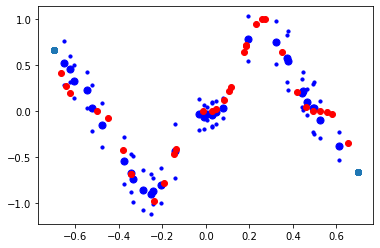

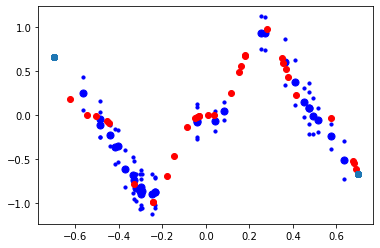

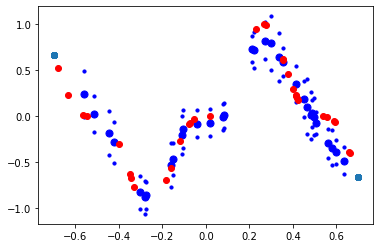

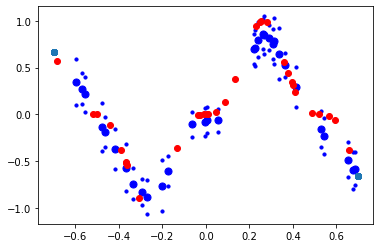

In [29]:
# #for x_rd,y_rd,u_rd in xt_rd,u:
# #figure()
# for j in range(4):
#     #model.sample()
#     #uxt_rd = model(xt_rd)

#     fig = plt.figure()
#     #plt.scatter(xt_rd[j,:,0].cpu().data.numpy(),uxt_rd[j,:,0].cpu().data.numpy(),color='b')
#     plt.scatter(xt_rd[j,:,0].cpu().data.numpy(),pred_mu[j,:,0].cpu().data.numpy(),s=50,color='b')
#     plt.scatter(xt_rd[j,:,0].cpu().data.numpy(),(pred_mu-2*pred_std)[j,:,0].cpu().data.numpy(),s=10,color='b')
#     plt.scatter(xt_rd[j,:,0].cpu().data.numpy(),(pred_mu+2*pred_std)[j,:,0].cpu().data.numpy(),s=10,color='b')
    
#     plt.scatter(xt_init[j,:,0].cpu().data.numpy(),u_init[j,:,0].cpu().data.numpy(),color='r')
#     plt.scatter(xt_bd[j,:,0].cpu().data.numpy(),u_bd[j,:,0].cpu().data.numpy())
    
#     plt.show()
    
    
# #plt.scatter(xt_rd[0,:,0].cpu().data.numpy(),f[0,:,0].cpu().data.numpy(),zorder=2)
# #plt.scatter(xt_rd[1,:,0].cpu().data.numpy(),rd_set[2][1,:,0].cpu().data.numpy())

    
# # for x_rd,y_rd,u_rd in xt_rd,u:
# #     figure()
# #     plt.scatter(xt_rd[0,:,0].cpu().data.numpy(),uxt_rd[1,:,0].cpu().data.numpy())
# #     plt.scatter(xt_rd[1,:,0].cpu().data.numpy(),rd_set[2][1,:,0].cpu().data.numpy())


In [30]:
#rd_set